# Computação Escalável - Exercício 1: paralelismo através de threads


In [48]:
import subprocess as sp
import matplotlib.pyplot as plt
import sys
import os

# Aumentando o tamanho do texto

In [68]:
!wget https://www.gutenberg.org/cache/epub/100/pg100.txt -O shakespeare.txt


--2024-03-08 20:01:24--  https://www.gutenberg.org/cache/epub/100/pg100.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5638549 (5.4M) [text/plain]
Saving to: ‘shakespeare.txt’

shakespeare.txt     100%[===================>]   5.38M  26.7MB/s    in 0.2s    

2024-03-08 20:01:25 (26.7 MB/s) - ‘shakespeare.txt’ saved [5638549/5638549]



In [69]:
with open('shakespeare.txt', 'r+b') as f:
    f.seek(0)
    content = f.read()
    for i in range(300):
        f.write(content)

Código principal

In [59]:
%%writefile main.cpp
#include <iostream>
#include <fstream>
#include <string>
#include <vector>
#include <thread>
#include <chrono>

using namespace std;


string TEXT_FILE_PATH = "./shakespeare.txt"; // Path to the text file
const string LOVE = "love";
const string HATE = "hate";

string line; // String to hold each line of the text file


int count_word_per_memory_block(const string& memoryBlock, const string& word) {
    int total = 0;

    size_t pos = memoryBlock.find(word);

    while (pos != string::npos) {
        bool is_valid_start = (pos == 0) || !isalpha(memoryBlock[pos - 1]);

        bool is_valid_end = (pos + word.length() == memoryBlock.length()) || !isalpha(memoryBlock[pos + word.length()]);

        if (is_valid_start && is_valid_end) {
            total++;
        }

        pos = memoryBlock.find(word, pos + 1);
    }

    return total;
}

bool isalpha(char c) {
    return (c >= 'a' && c <= 'z') || (c >= 'A' && c <= 'Z');
}


// function that returns a pair of integers that represent the number of times the word "love" and "hate" appear in the text
void count_word(const string& memoryBlock, int& loveCount, int& hateCount) {
    loveCount = count_word_per_memory_block(memoryBlock, LOVE);
    hateCount = count_word_per_memory_block(memoryBlock, HATE);
}

int main(int argc, char* argv[]) {

    const int NUM_THREADS = argc < 2 ? 1 : atoi(argv[1]);
    // Measure pre-processing time
    auto start = chrono::high_resolution_clock::now();

    ifstream textFile (TEXT_FILE_PATH);

    int lineCount = 0;

    while (getline(textFile, line)) {
        lineCount++;
    }

    int linesPerThread = lineCount / NUM_THREADS;
    int remainingLines = lineCount % NUM_THREADS;

    vector<string> memoryBlocks;

    // Reset file pointer to beginning
    textFile.clear();
    textFile.seekg(0);

    for (int threadIndex = 0; threadIndex < NUM_THREADS; threadIndex++) {

        int currentThreadLineCount;

        // Assign lines to memory block
        if (remainingLines > 0) {
            currentThreadLineCount = linesPerThread + 1;
            remainingLines--;
        } else {
            currentThreadLineCount = linesPerThread;
        }

        string memoryBlock;

        for(int i = 0; i < currentThreadLineCount; i++){
            getline(textFile, line);
            memoryBlock += line + "\n";
        }


        memoryBlocks.push_back(memoryBlock);
    }

    textFile.close();

    // Finish pre-processing time
    auto end = chrono::high_resolution_clock::now();
    chrono::duration<double> preProcessingTime = end - start;


    // Measure processing time
    start = chrono::high_resolution_clock::now();

    auto* threads = new thread[NUM_THREADS];

    int countLove[NUM_THREADS];
    int countHate[NUM_THREADS];

    for (int i = 0; i < NUM_THREADS; i++) {
        threads[i] = thread(count_word, ref(memoryBlocks[i]), ref(countLove[i]), ref(countHate[i]));
    }

    int totalLoveCount = 0;
    int totalHateCount = 0;

    // join the threads
    for (int i = 0; i < NUM_THREADS; i++) {
        threads[i].join();
        totalLoveCount += countLove[i];
        totalHateCount += countHate[i];
    }

    delete[] threads;

    // Finish processing time
    end = chrono::high_resolution_clock::now();
    chrono::duration<double> processingTime = end - start;


    // Threads information
    cout << "Numero de threads: " << NUM_THREADS << endl;
    cout << "Tamanho de bloco de cada thread = Numero de linhas por thread (as linhas restantes sao distribuidas pelas primeiras threads): " << linesPerThread << endl;

    // Time information
    cout << "Tempo de preparacao (s): " << preProcessingTime.count() << endl;
    cout << "Tempo de execucao da pesquisa (s): " << processingTime.count() << endl;
    cout << "Tempo total decorrido (s): " << preProcessingTime.count() + processingTime.count() <<  endl;

    // Results
    cout << "Quantidade de ocorrencias de 'love': " << totalLoveCount << endl;
    cout << "Quantidade de ocorrencias de 'hate': " << totalHateCount << endl;
    cout << "A palavra que aparece mais vezes eh: " << (totalLoveCount > totalHateCount ? "love" : "hate") << endl;

    return 0;
}

Overwriting main.cpp


In [60]:
! g++ main.cpp -o main

In [ ]:
env = os.environ.copy()

n_threads = []
total_time = []
search_time = []


for i in range(1, 101):
    print(i)
    output = sp.run(["./main "+ str(i)], capture_output=True, shell=True, env=env)
    output = output.stdout.decode("utf-8").split("\n")
    n_threads.append(int(output[0].split(": ")[1]))
    total_time.append(float(output[4].split(": ")[1]))
    search_time.append(float( output[3].split(": ")[1]))


In [67]:
# export data

import csv

with open('results.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',',
                            quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['n_threads', 'total_time', 'search_time'])

    for i in range(len(n_threads)):
        writer.writerow([n_threads[i], total_time[i], search_time[i]])


# Total time per thread

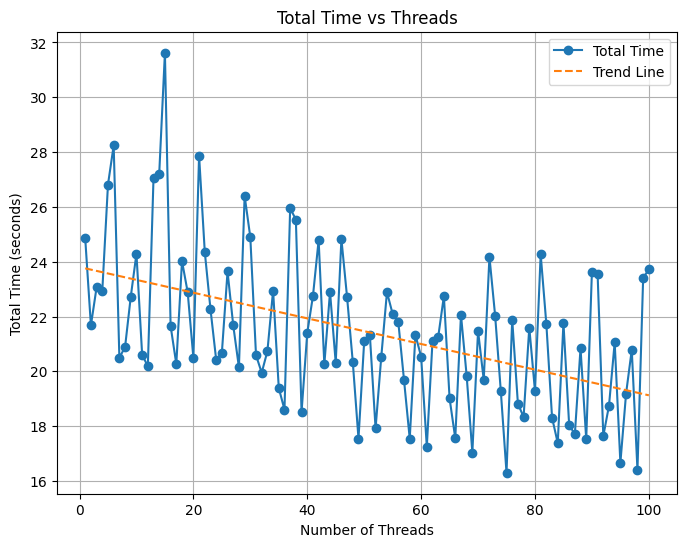

In [75]:
import numpy as np
from sklearn.linear_model import LinearRegression

n_threads = np.array(n_threads).reshape(-1, 1)
total_time = np.array(total_time)
search_time = np.array(search_time)

# Fit linear regression models
total_time_model = LinearRegression().fit(n_threads, total_time)
search_time_model = LinearRegression().fit(n_threads, search_time)

# Generate predictions for trend lines
total_time_trend = total_time_model.predict(n_threads)
search_time_trend = search_time_model.predict(n_threads)

plt.figure(figsize=(8, 6))
plt.plot(n_threads, total_time, marker='o', label='Total Time')
plt.plot(n_threads, total_time_trend, label='Trend Line', linestyle='--')
plt.xlabel('Number of Threads')
plt.ylabel('Total Time (seconds)')
plt.title('Total Time vs Threads')
plt.legend()
plt.grid(True)
plt.show()

# Search time per thread


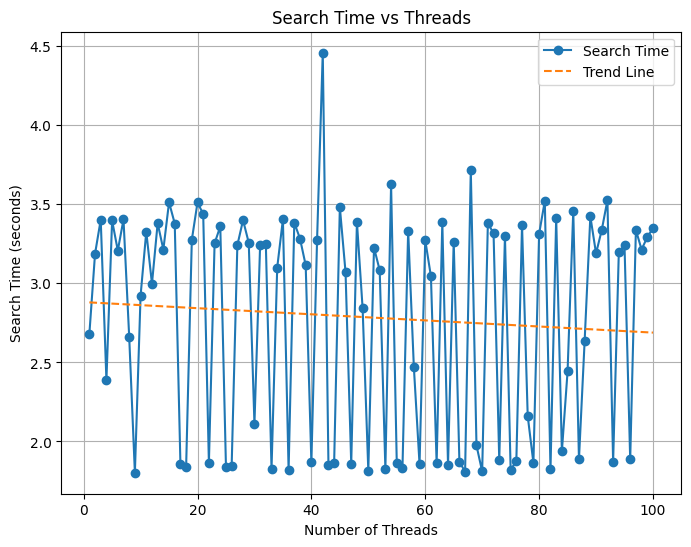

In [76]:


plt.figure(figsize=(8, 6))
plt.plot(n_threads, search_time, marker='o', label='Search Time')
plt.plot(n_threads, search_time_trend, label='Trend Line', linestyle='--')
plt.xlabel('Number of Threads')
plt.ylabel('Search Time (seconds)')
plt.title('Search Time vs Threads')
plt.legend()
plt.grid(True)
plt.show()
